# German License Plate Recognition - Model Training and Evaluation
This notebook trains the License Recognition model using Tensorflow 2.0.

Main steps:
- Download the license recognition data set
- Load and split the data into a train, validation and test set
- Explain the data augmentation used
- Create data genrators and OCR model
- Train and evaluate a Keras model
- Convert the trained Keras model into an TFLite model, which can be used by the Android app
- Test the trained License Recognition (TFLite) model

The following diagram shows the directory structure that is created when executing the individual steps of this notebook:

Import common modules...

In [13]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import json
import os.path
import random
import re
import time
import cv2
import requests
import pandas as pd
import progressbar
import tarfile
import tensorflow as tf
import zipfile
import matplotlib
import requests

from google_drive_downloader import GoogleDriveDownloader as gdd
from distutils.version import StrictVersion
from imutils import paths
from PIL import Image

Check the Tensorflow version...

In [2]:
print ("Tensorflow: {}".format(tf.__version__))

if StrictVersion(tf.__version__.split('-')[0]) < StrictVersion('2.0.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v2.0.0')

if StrictVersion(tf.__version__.split('-')[0]) >= StrictVersion('3.0.0'):
    raise ImportError('Please downgrade your TensorFlow installation to v2.0.*.')

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

Tensorflow: 2.0.0
GPU device: /device:GPU:0


Define variables for training and often used directories and files

In [3]:
from config.license_recognition import config

# datasets
GLP_HDF5 = 'data/license_recognition/background.h5'
BACKGRND_HDF5 = 'data/license_recognition/glp.h5'

# image size <=> network input size
IMAGE_WIDTH = config.IMAGE_WIDTH
IMAGE_HEIGHT = config.IMAGE_HEIGHT

# training parameter
DOWNSAMPLE_FACTOR = config.DOWNSAMPLE_FACTOR
MAX_TEXT_LEN = config.MAX_TEXT_LEN

BATCH_SIZE = 64
NUM_EPOCHS = 1000

# supported optimizer methods: sdg, rmsprop, adam, adagrad, adadelta
OPTIMIZER = 'adagrad'

OUTPUT_PATH = 'output/license_recognition'
DOCUMENTATION_PATH = 'documentation'
MODEL_NAME = 'glpr-model'

MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + '-weights.h5'
MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + ".h5"
TEST_IMAGES = 'data/license_recognition/test_images'

# create model output directory
os.makedirs(os.path.join(OUTPUT_PATH, OPTIMIZER), exist_ok=True)

print("GLP Dataset:        {}".format(GLP_HDF5))
print("Background Dataset: {}".format(BACKGRND_HDF5))
print("Batch Size:         {}".format(BATCH_SIZE))
print("Epochs (max):       {}".format(NUM_EPOCHS))
print("Image Size:         ({}, {})".format(IMAGE_WIDTH, IMAGE_HEIGHT))
print("Optimizer:          {}".format(OPTIMIZER))
print("Model Name:         {}".format(MODEL_NAME))
print("Output Path:        {}".format(OUTPUT_PATH))
print("Model Weights Path: {}".format(MODEL_WEIGHTS_PATH))
print("Model Path:         {}".format(MODEL_PATH))
print("Documentation Path: {}".format(DOCUMENTATION_PATH))
print("Test Images Path:   {}".format(TEST_IMAGES))

GLP Dataset:        data/license_recognition/background.h5
Background Dataset: data/license_recognition/glp.h5
Batch Size:         64
Epochs (max):       1000
Image Size:         (128, 64)
Optimizer:          adagrad
Model Name:         glpr-model
Output Path:        output/license_recognition
Model Weights Path: output/license_recognition\adagrad\glpr-model-weights.h5
Model Path:         output/license_recognition\adagrad\glpr-model.h5
Documentation Path: documentation
Test Images Path:   data/license_recognition/test_images


# Train License Recoginition Model
This section describes the necessary steps to train the License Recognition model and convert it into a TFLite model that can be used by the Android app.

**NOTE:** If you have already trained and exported the license recognition model, you can skip the training- and export steps and proceed directly with testing...

### Load License Recognition Dataset
First we have to provide the data collections needed for the training. Either by creating them ourselves as described in Notebook [3_License_Recognition_Data_Collection_And_Exploration](3_License_Recognition_Data_Collection_And_Exploration.ipynb), or by downloading the finished data set from Google Drives to our local project directory and unpacking it there. To download the dataset you can use the following command, if you have already created the dataset you can skip this step.

In [15]:
gdd.download_file_from_google_drive(file_id='1D2jhjQQOnlXtYpW0_4qTm2Q9DR34KxdT',
                                    dest_path='data/license_recognition/glpr.zip',
                                    unzip=True)

Load the the generated license plate and backgraound data set and display some examples...

In [4]:
from license_plate_image_augmentor import LicensePlateImageAugmentor
from utils.io import Hdf5DatasetLoader

In [8]:
loader = Hdf5DatasetLoader()
background_images = loader.load(GLP_HDF5, shuffle=True, max_items=10000)
images, labels = loader.load(BACKGRND_HDF5, shuffle=True)

In [8]:
def show_images(images, labels, figsize=(15, 5)):
    cols = 5
    rows = len(images) // cols

    image_index = 0
    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            image = images[image_index]
            axarr[r, c].axis("off")
            axarr[r, c].title.set_text(labels[image_index])
            axarr[r, c].imshow(image, cmap='gray')
            image_index += 1

    plt.show()

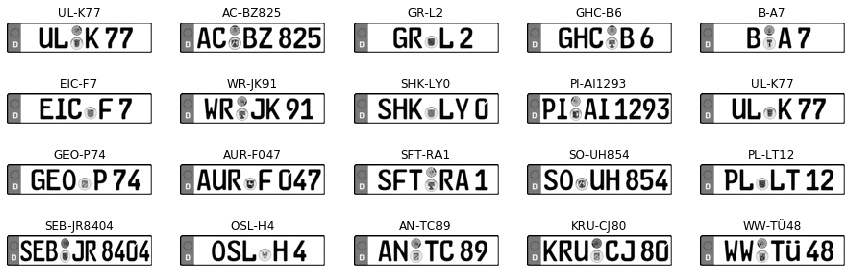

In [9]:
show_images(images[4:], labels[4:])

The generated plate images are perfect, synthetic images. However, real camera images always have different disturbing factors. In order to train a model that works reliably with real images, we must therefore "simulate" real images, i.e. randomly generate artificial disturbances. The common technique do do this is [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation). With each training run, new images are created from the generated images, which are then provided with artificially generated disturbances.This technique reduces the risk of the model learning by memorizing (overfitting) during training, since the training data is varied again and again.

The following data augmentation techniques are used for this project:
- Varying background
- Random rotation in X,Y,Z
- Scaling
- Variation of brightness
- Slight interference effects (Blur)

The python class `LicensePlateImageAugmentor` implements the data augmentation. In the following steps we will create an `augmentor` object and let you see some examples...

In [9]:
augmentor = LicensePlateImageAugmentor(IMAGE_WIDTH, IMAGE_HEIGHT, background_images)

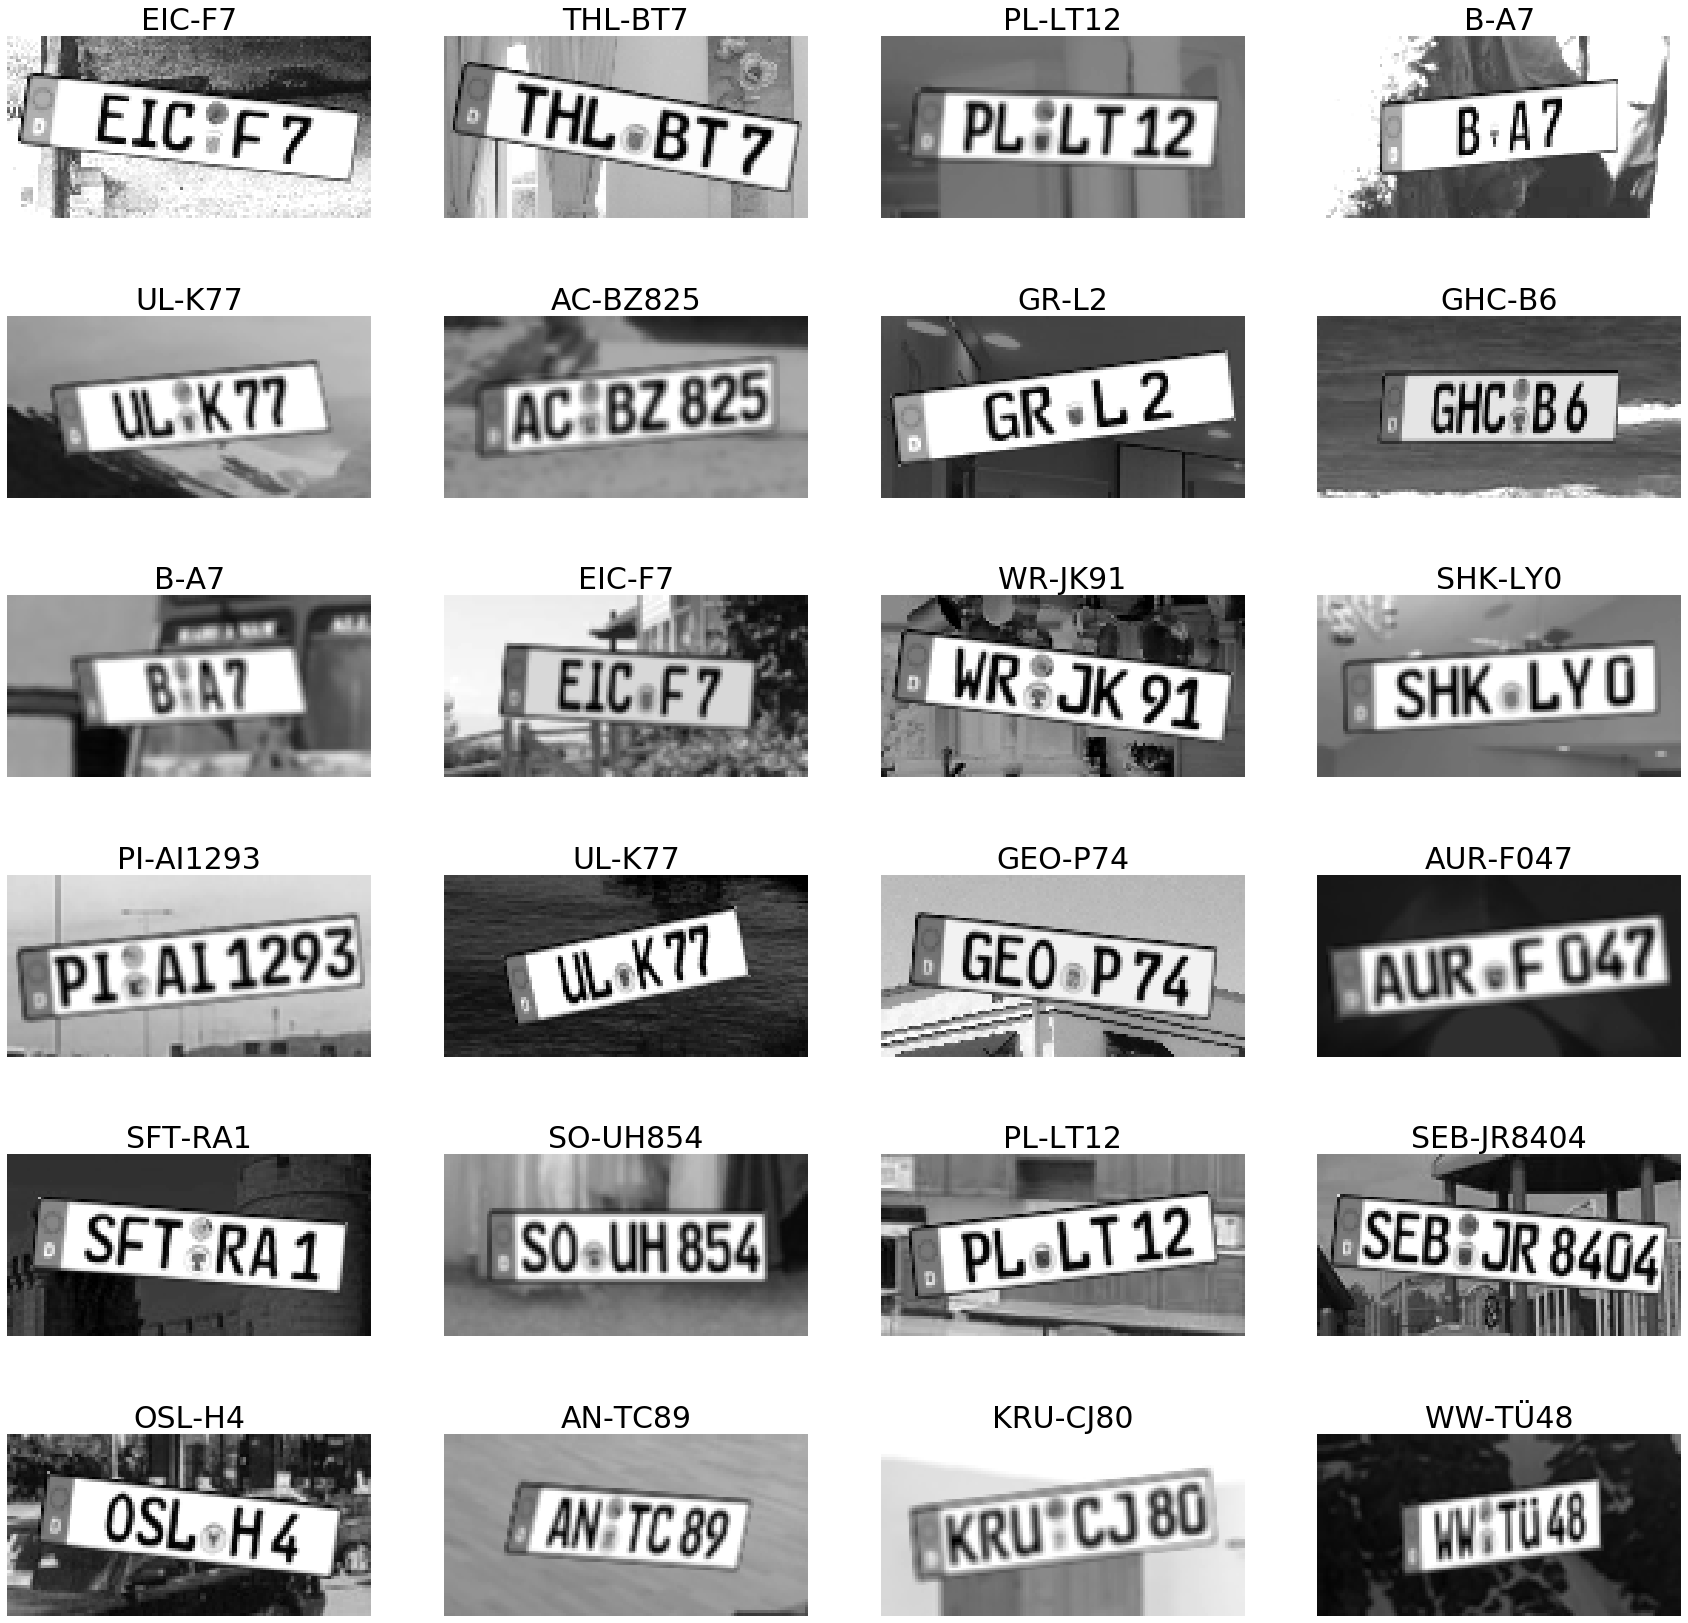

In [11]:
cols = 4
rows = len(images) // cols

image_index = 0
fig, axarr = plt.subplots(rows, cols, figsize=(30, 30))
for r in range(rows):
    for c in range(cols):
        image = images[image_index]
        image = augmentor.generate_plate_image(image)
        axarr[r, c].axis("off")
        axarr[r, c].title.set_size(30)
        axarr[r, c].title.set_text(labels[image_index])
        axarr[r, c].imshow(image, cmap='gray')
        image_index += 1

plt.show()

It is a general technique to split the data for training a model into training, validation and test data. It is particularly important never to use the test data for training. We use the `train_test_split` function from the sklearn package to split the data accordingly.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Train dataset size:      {}".format(X_train.shape[0]))
print("Validation dataset size: {}".format(X_val.shape[0]))
print("Test dataset size:       {}".format(X_test.shape[0]))

Train dataset size:      91561
Validation dataset size: 22891
Test dataset size:       28614


For the training we need one data generator per data set (training, validation and test), which selects a random series of images (BATCH) from the data set at each training period and applies data augmentation. The implementation is realized in the python class `LicensePlateDatasetGenerator`.

In [13]:
from licence_plate_dataset_generator import LicensePlateDatasetGenerator

train_generator = LicensePlateDatasetGenerator(X_train, y_train, IMAGE_WIDTH, IMAGE_HEIGHT,
                                               DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                               augmentor)

val_generator = LicensePlateDatasetGenerator(X_val, y_val, IMAGE_WIDTH, IMAGE_HEIGHT,
                                             DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                             augmentor)

test_generator = LicensePlateDatasetGenerator(X_test, y_test, IMAGE_WIDTH, IMAGE_HEIGHT,
                                              DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                              augmentor)

Here's an example of a batch...

C:\Users\Andreas\Anaconda3\envs\mlnd\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


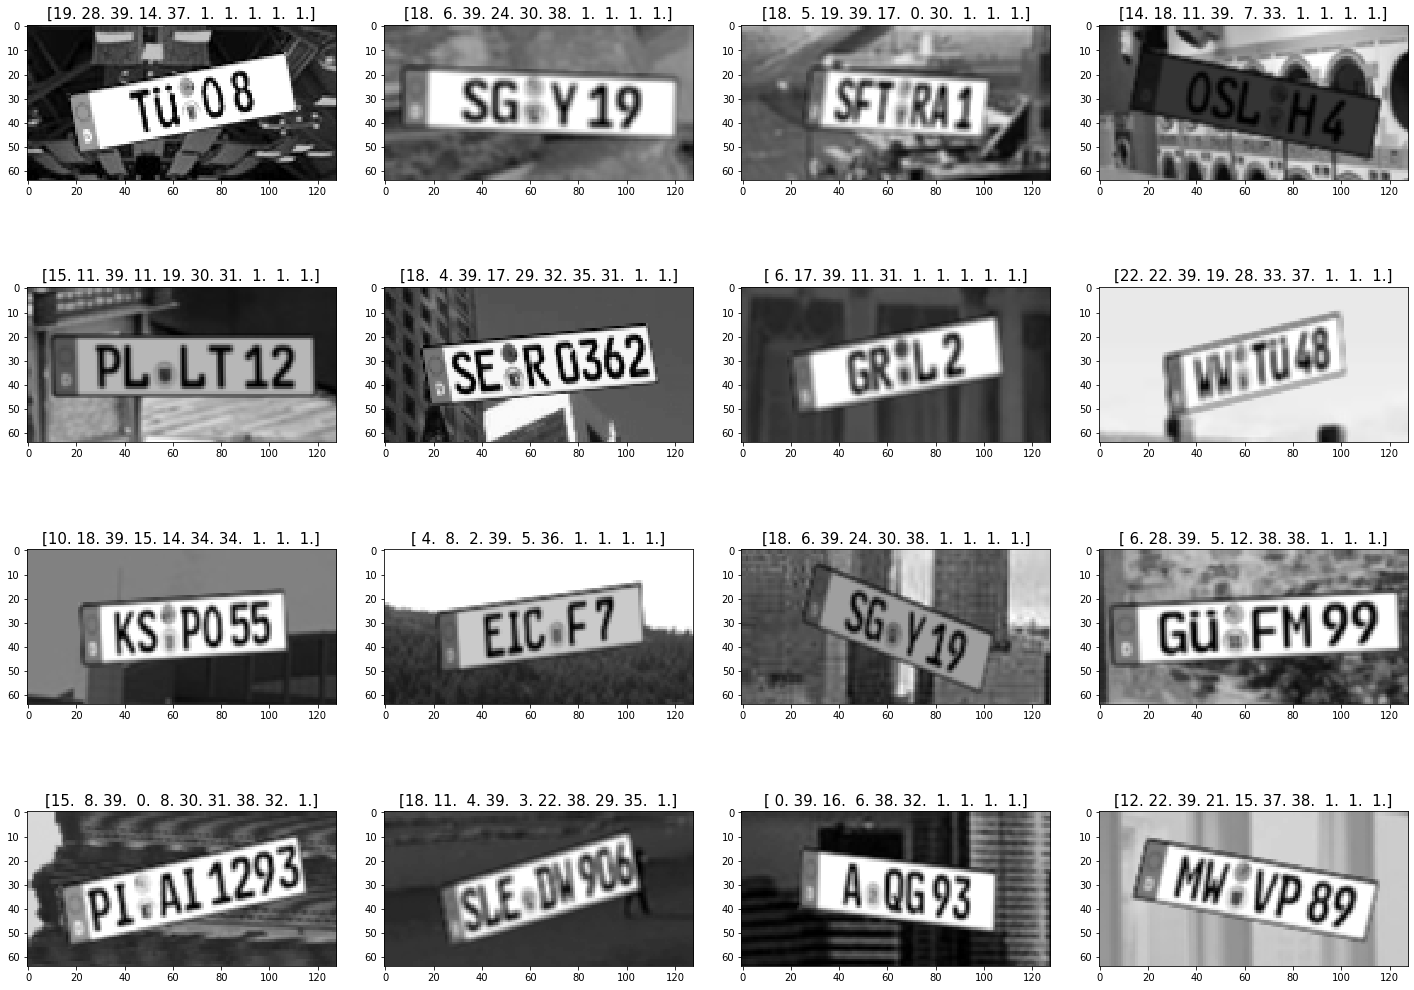

In [14]:
inputs = next(train_generator.generator())

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(20,15))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.T.reshape(config.IMAGE_HEIGHT, config.IMAGE_WIDTH)
        ax.title.set_size(15)
        ax.title.set_text(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
        
plotImages(inputs["input"], inputs["labels"], int(16 / 4), 4)

In the next step we create the Keras model for license recognition, which we will train afterwards. The code is based on the the [Image OCR](https://keras.io/examples/image_ocr/) example from [Keras](https://keras.io/).

In [21]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from utils.nn.conv import OCR
from label_codec import LabelCodec
from train_helper import TrainHelper
    
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, input_length, label_length, name='CTCLoss'):
        super().__init__(name=name)
        self.input_length = input_length
        self.label_length = label_length

    def call(self, labels, predictions):
        return tf.keras.backend.ctc_batch_cost(labels, predictions, self.input_length, self.label_length)

tf.compat.v1.disable_eager_execution()

labels = Input(name='labels', shape=(MAX_TEXT_LEN,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')

inputs, outputs = OCR.conv_bgru((IMAGE_WIDTH, IMAGE_HEIGHT, 1), len(LabelCodec.ALPHABET) + 1)

train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=outputs)
train_model.add_loss(CTCLoss(input_length, label_length)(labels, outputs))
train_model.compile(loss=None, optimizer=TrainHelper.get_optimizer(OPTIMIZER))

predict_model = Model(inputs=inputs, outputs=outputs)
predict_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 64, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 64, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 64, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 128, 64, 16)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 32, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 32, 16)        64  

Graphical output of the model architecture... 

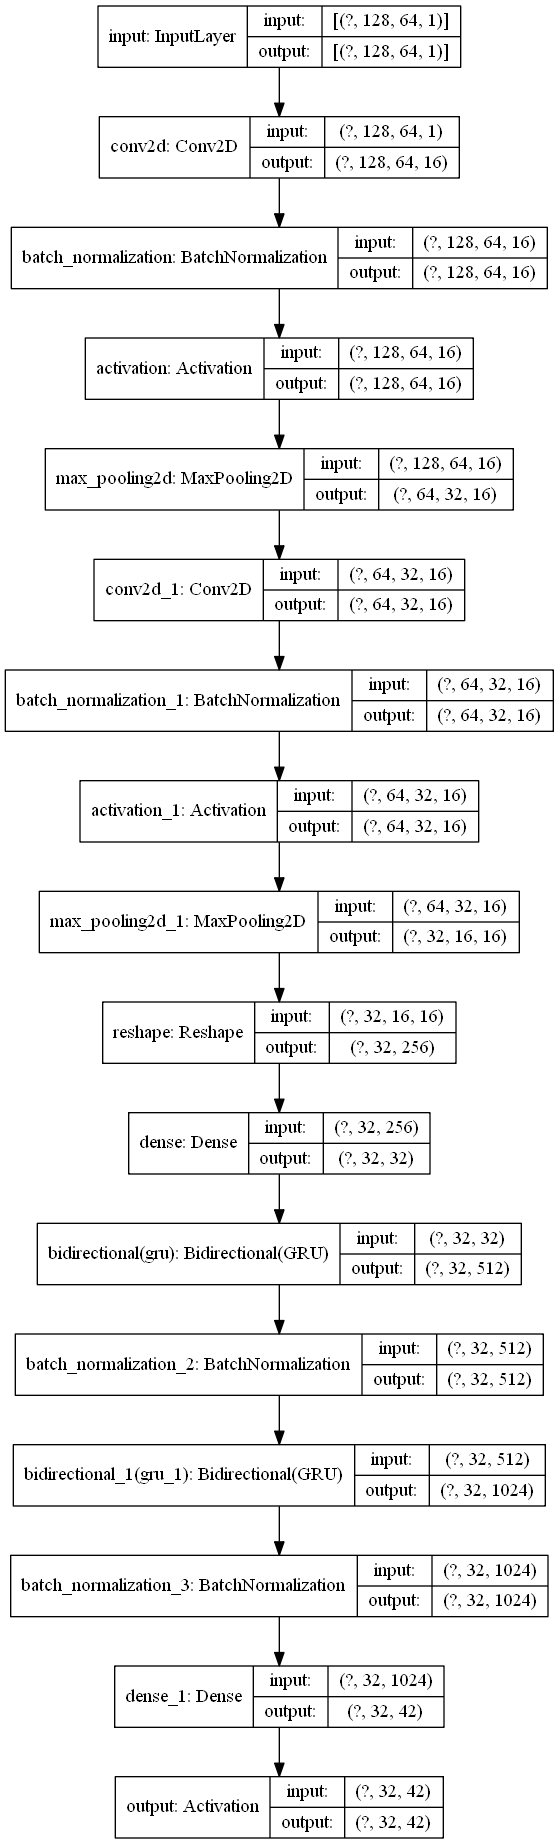

In [22]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

model_architecture_file = os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + '.png'
plot_model(predict_model, to_file=model_architecture_file, show_shapes=True)
Image(filename=model_architecture_file, width=400)

Start the training...

The 'TrainHelper' generates callbacks to stop the training for the time being if there is no improvement (EarlyStopping), saving the best checkpoint after each training period and for training monitoring with Tensorboard.

You can monitor the training process with `Tensorboard` by running the command `tensorboard --logdir=%OUTPUT_PATH%/%OPTIMIZER%/logs` in another console. 

In [ ]:
history = train_model.fit(
    train_generator.generator(),
    steps_per_epoch=train_generator.numImages // BATCH_SIZE,
    validation_data=val_generator.generator(),
    validation_steps=val_generator.numImages // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=TrainHelper.get_callbacks(OPTIMIZER, MODEL_WEIGHTS_PATH), verbose=1)

After training the model, we test it with our test data and calculate the score...

In [ ]:
from tensorflow.keras.models import save_model

predict_model.load_weights(MODEL_WEIGHTS_PATH)
save_model(predict_model, filepath=MODEL_PATH, save_format="h5")

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + "-train-history-" + OPTIMIZER + ".png")
plt.show()

In [ ]:
inputs = next(test_generator.generator())
score = train_model.evaluate(inputs, verbose=0)
print('Test loss: {0:.4f}'.format(score))

In [ ]:
predict_model.save(os.path.join(OUTPUT_PATH, OPTIMIZER, "saved_model"), save_format='tf')

Finally we convert the trained Keras model into a TFLite model which can be used by the Android app to recognize the license plates.

In [ ]:
from tensorflow_core.lite.python.lite import TFLiteConverter, Optimize

converter = TFLiteConverter.from_keras_model_file(MODEL_PATH)
converter.optimizations.append(Optimize.DEFAULT)
converter.target_spec.supported_types.append(tf.float16)
converter.experimental_new_converter = True
tflite_model = converter.convert()

open(TFLITE_MODEL_PATH, "wb").write(tflite_model)

# Test License Recoginition Model
The following steps show an example of how the license recognition works...

In [16]:
def show_image(image):
    plt.axis("off")
    plt.title(label)
    plt.imshow(image, cmap='gray')
    plt.show()

First we load our trained License Reginition model...

In [17]:
from tensorflow.keras.models import load_model

tf.compat.v1.disable_eager_execution()
model = load_model(MODEL_PATH, compile=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Since the camera images can have different sizes, but the model expects a fixed image size of 128 x 64 pixels, the camera image must be adapted to the corresponding size. To do this, the image is first scaled to a width of 128 pixels and then the height is adjusted to 64 pixels, taking the aspect ratio into account. This means that the image is either slightly cut off at the top and bottom, or it is filled up at the top and bottom. All this is done by the python class `AspectAwarePreprocessor.

In [18]:
from PIL import Image
from utils.preprocessing import AspectAwarePreprocessor

preprocessor = AspectAwarePreprocessor(IMAGE_WIDTH, IMAGE_HEIGHT)

The result shows above the original image in color as supplied by the camera. The lower image shows the grayscale image adapted to the size of 128 x 64 pixels as it is passed to the model. The diagram on the right shows the activations, which indicates how safe or not the detection is.

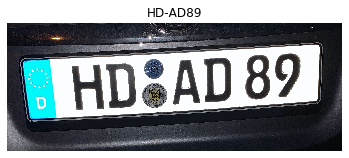

Predicted:   HD-AD89
True:        HD-AD89
=> True


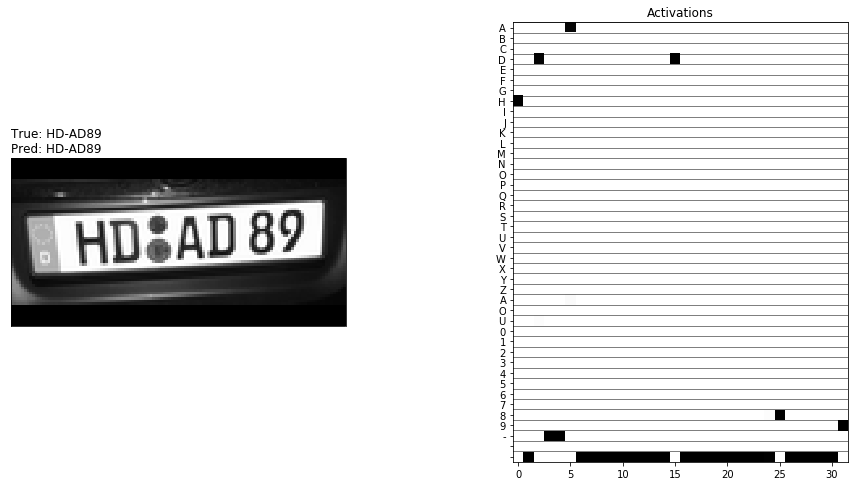

In [24]:
from label_codec import LabelCodec
from matplotlib import gridspec

img_filename = random.choice(os.listdir(TEST_IMAGES))
img_filepath = os.path.join(TEST_IMAGES, img_filename)
label = img_filename.split(".")[0].split("#")[0]

image = Image.open(img_filepath) 

# original image
show_image(image)

# predict
image = preprocessor.preprocess(image)
image = image.astype(np.float32) / 255.

image = np.expand_dims(image.T, axis=-1)

predictions = model.predict(np.asarray([image]))
pred_number = LabelCodec.decode_prediction(predictions[0])

fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(1, 2, wspace=.5, hspace=0.1)
ax1 = plt.Subplot(fig, outer[0])
fig.add_subplot(ax1)
print('Predicted: %9s\nTrue:      %9s\n=> %s' % (pred_number, label, pred_number == label))
image = image[:, :, 0].T
ax1.set_title('True: {}\nPred: {}'.format(label, pred_number), loc='left')
ax1.imshow(image, cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.Subplot(fig, outer[1])
fig.add_subplot(ax2)
ax2.set_title('Activations')
ax2.imshow(predictions[0].T, cmap='binary', interpolation='nearest')
ax2.set_yticks(list(range(len(LabelCodec.ALPHABET) + 1)))
ax2.set_yticklabels(LabelCodec.ALPHABET)  # + ['blank'])
ax2.grid(False)
for h in np.arange(-0.5, len(LabelCodec.ALPHABET) + 1 + 0.5, 1):
    ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)